# Lab 6: Bandits


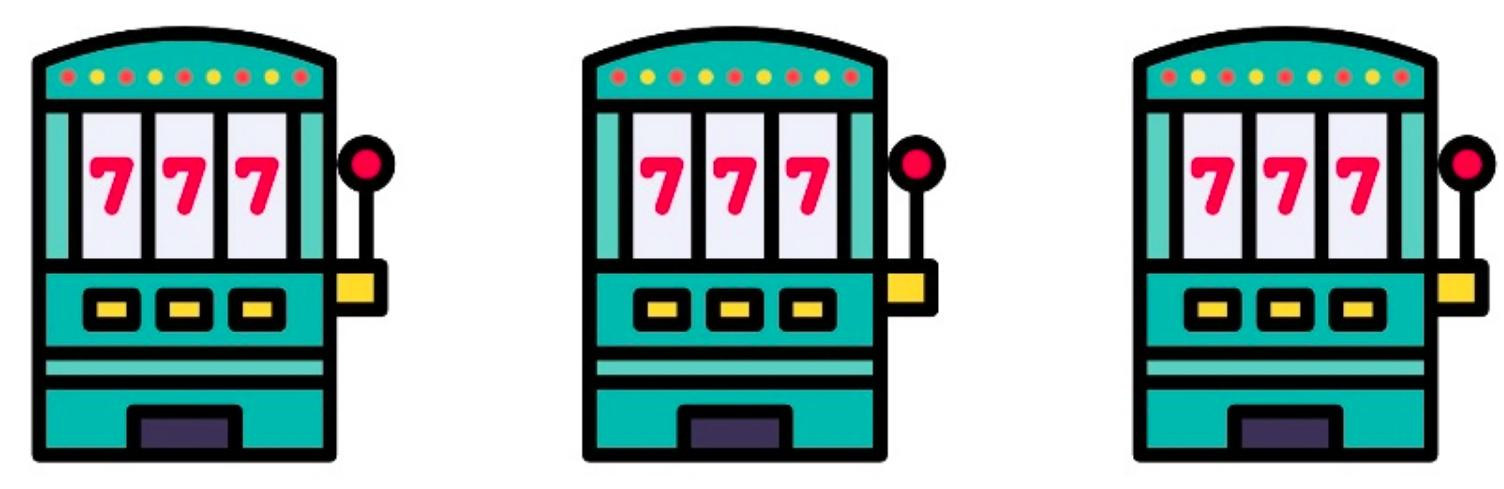

Each of $k$ bandits have a mean value $q^*(a); a \in \{1..k\}$.

Let's assume that the actual returns $r_t$ are normally distributed around $q^*(a)$:

$r_t(a) = q^*(a) + \mathcal N(0,1)$.

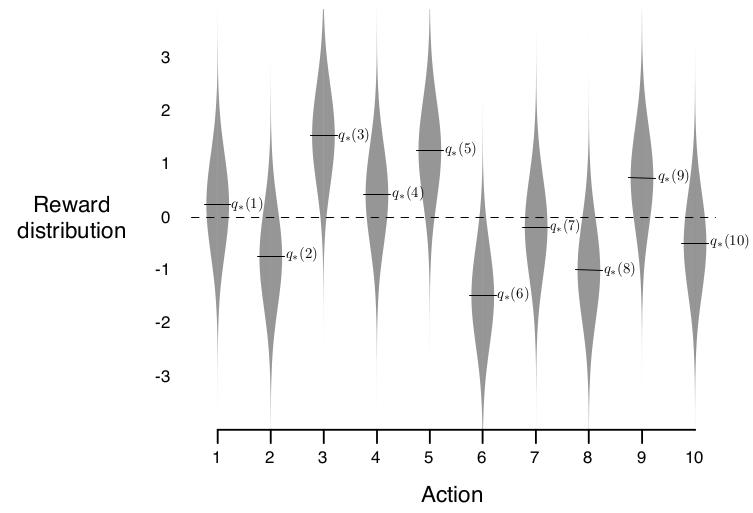

How to maximize the reward in long term? Obviously, the optimal strategy is to always choose $a_{opt} = \text{argmax}_{a} q^*(a)$.
But we don't know which arm is the best, as we  can only *sample* $r_t$ at the time step t. **Exploration vs. exploitation** problem!

## $\epsilon$-greedy strategy

Let's have our current estimate of $q^*(a)$ at time $t$ as a mean of rewards we've seen so far for this action:
$$Q_t(a) = \frac{ \sum_{i=1}^{t-1} r_i \cdot \mathbb{1}_{a_i=a} } { \sum_{i=1}^{t-1} \mathbb{1}_{a_i=a}
 }$$

If the denominator is zero, let's use some default value, say 0 for now.

The $\epsilon$-greedy strategy selects our best estimate $a_t = \text{argmax}_a Q_t(a)$ most of the time, but with probability $\epsilon$, it chooses a random action.

**Question**: In $\epsilon$-greedy action selection, for the case of two actions and $\epsilon = 0.5$, what is the probability that the greedy action is selected?(0,75)



# Task 1

We will now implement the $ϵ$-greedy algorithm for the bandit problem. Write the loop for $\epsilon$-greedy.

In [23]:
import numpy as np, copy
from typing import List, Dict
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler

mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk') # more contrasting colors
plt.rcParams['figure.figsize'] = [16, 10]

class BanditProblem():
  def __init__(self, bandits_q: List[float]) -> None:
    self.bandits_q = bandits_q

  def sample(self, a: int) -> float:
    return self.bandits_q[a] + np.random.normal(0, 1)

  def action_count(self) -> int:
    return len(self.bandits_q)

  def reset(self) -> None:  # not used now
    pass

  def __repr__(self) -> str:
    return "BanditProblem " + str(self.bandits_q)

def exp_egreedy(problem, eps: float, init_Q: List[float]) -> List[float]:
  Q = np.array(init_Q, dtype=np.float32)                      # our current estimate; np.array copies the values
  a_count = np.zeros(problem.action_count(), dtype=np.int32)  # number of times a was selected
  r_history = []

  problem.reset()

  for step in range(1, 1000):
    # a: Sample an action with e-greedy policy.
    # b: Perform the action and update the Q values with running mean
    # c: Append the sampled reward to history
    # Hint: you can use np.argmax(x) and np.random.randint(x)
    ''' Greedy algorithm
    a = np.argmax(Q)
    r = problem.sample(a)
    a_count[a] += 1
    Q[a] = Q[a] + (r - Q[a])/a_count[a]
    r_history.append(r)
    '''

    #eps-greedy algorithm
    if np.random.rand() > eps:
        a = np.argmax(Q)
    else:
        a = np.random.randint(problem.action_count())

    r = problem.sample(a)
    a_count[a] += 1
    Q[a] = Q[a] + (r - Q[a])/a_count[a]
    r_history.append(r)

    # Your code here
    # raise NotImplementedError
  return r_history

# auxiliary method to run an experiment several times and plot the results
def run_experiment(exp_fn, exp_args: Dict, runs: int=400) -> None:
    run_returns = []

    for r in range(runs):
      run_returns.append(exp_fn(**exp_args)) # the **exp_args notation expands a dictionary as function parameters

    avg_return = np.mean(run_returns, axis=0)
    plt.plot(avg_return, label=f'{exp_args}')

# call at the end to show all plots
def show_plot() -> None:
  plt.legend()
  plt.xlabel("steps")
  plt.ylabel("averaged reward")
  plt.show()

Now, let's have a look at how $\epsilon$-greedy strategy does for different $\epsilon$: \\
**(it takes a few seconds to compute)**

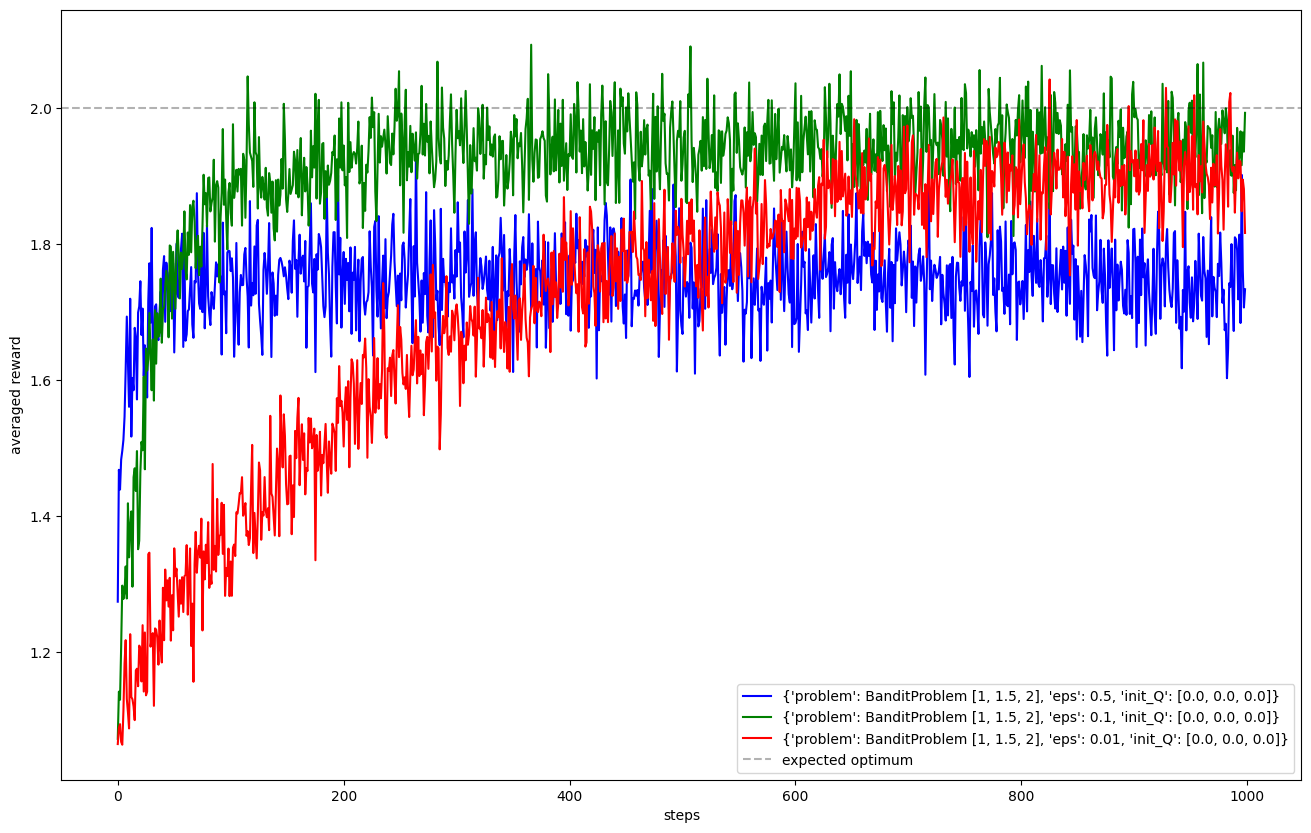

In [24]:
problem = BanditProblem(bandits_q = [1, 1.5, 2])

for eps in [0.5, 0.1, 0.01]:
  exp_args = {"problem": problem, "eps": eps, "init_Q": [0., 0., 0.]}
  run_experiment(exp_egreedy, exp_args)

plt.axhline(2., linestyle='--', color='k', alpha=0.3, label='expected optimum')

show_plot()



**Question:**
In the above graph, why are some returns above the dashed line?



**Question:**
Look at the resulting graph - which strategy performs best in the long run? Which one improves the quickest?


**Question:**
Can you combine both quick improvement and an optimal strategy in the end?



**Question:**
What if the problem is non stationary (i.e., the dynamics of the problem change over time)? Is the average still a good idea?



# Task 2
Let's also implement the exponential moving average:

In [29]:
def exp_egreedy_expmean(problem, eps: float, init_Q: List[float], alpha: float) -> List[float]:
  Q = np.array(init_Q, dtype=np.float32)                      # our current estimate; np.array copies the values
  a_count = np.zeros(problem.action_count(), dtype=np.int32)  # number of times a was selected
  r_history = []

  problem.reset()

  for step in range(1, 1000):
    # TODO: fill the loop
    if np.random.rand() > eps:
      a = np.argmax(Q)
    else:
      a = np.random.randint(problem.action_count())

    r = problem.sample(a)
    a_count[a] += 1
    Q[a] += alpha * (r - Q[a])
    r_history.append(r)

    # Your code here
    #raise NotImplementedError
  return r_history

And let's test it.

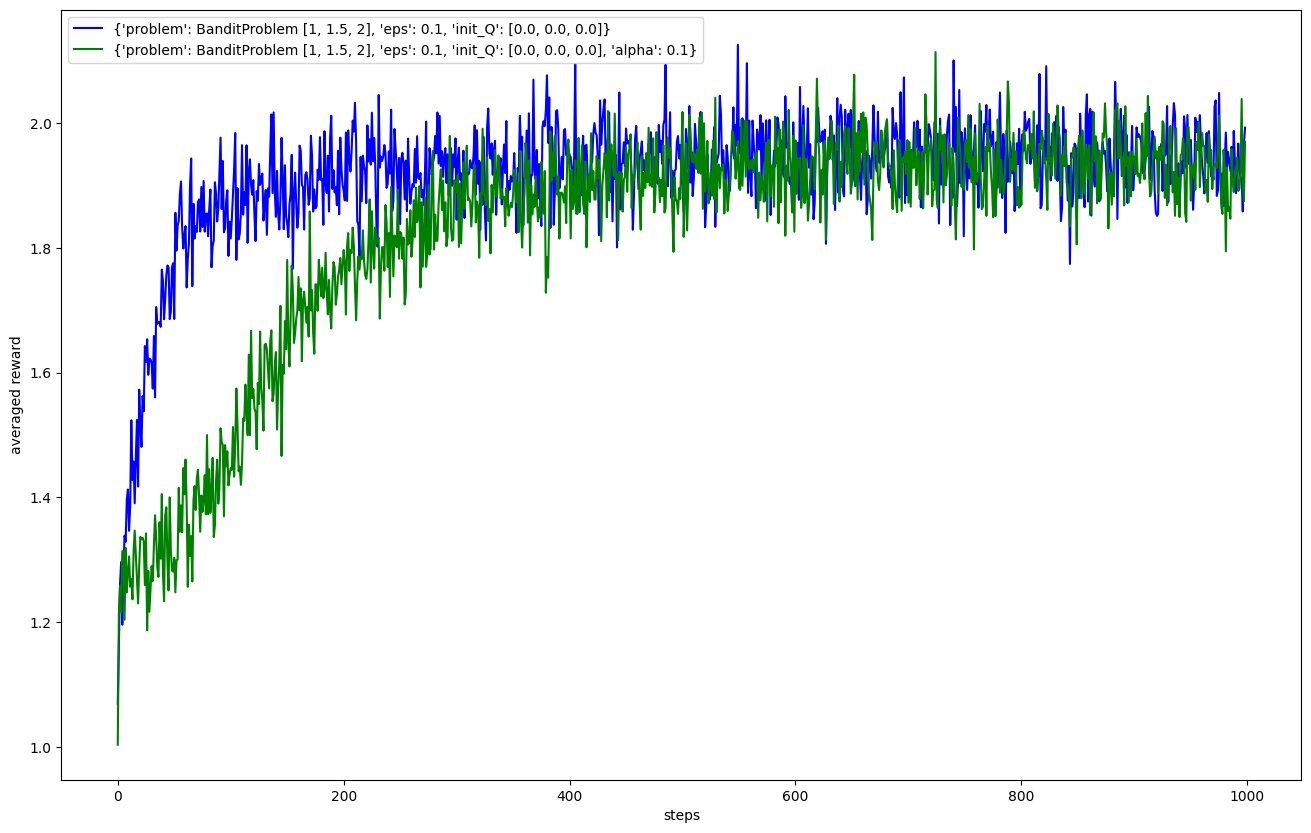

In [30]:
run_experiment(exp_egreedy, {"problem": problem, "eps": 0.1, "init_Q": [0., 0., 0.]})
run_experiment(exp_egreedy_expmean, {"problem": problem, "eps": 0.1, "init_Q": [0., 0., 0.], "alpha": 0.1})

show_plot()

So far, it does not seem to do any better.

## Optimistic initialization

We can also promote exploration with optimistic initialization. That is, if we set the initial Q values high, the algorithm needs to select each action to learn their value.

**Question**: Explain the difference bw. exponential and regular mean in this case.


Let's have a look.

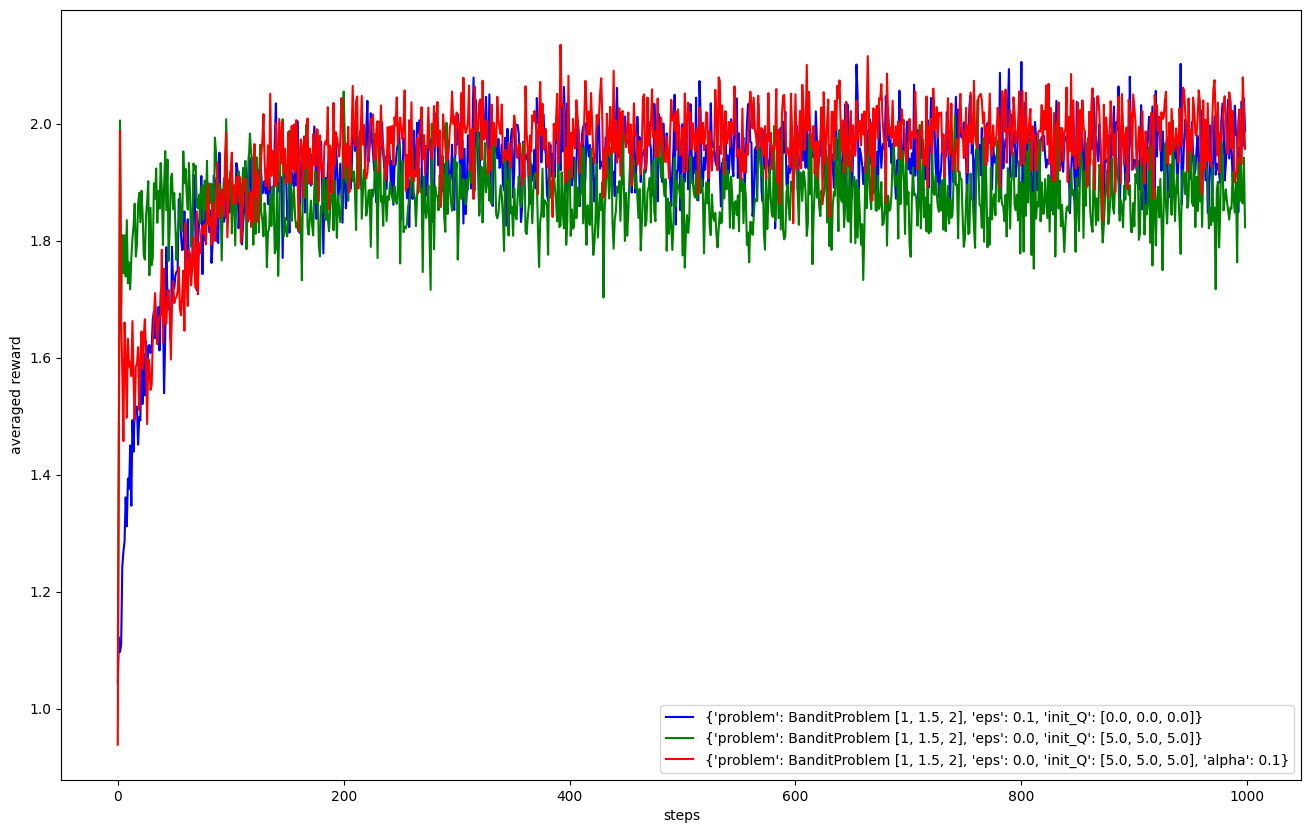

In [31]:
run_experiment(exp_egreedy, {"problem": problem, "eps": 0.1, "init_Q": [0., 0., 0.]})
run_experiment(exp_egreedy, {"problem": problem, "eps": 0.,  "init_Q": [5., 5., 5.]})
run_experiment(exp_egreedy_expmean, {"problem": problem, "eps": 0.,  "init_Q": [5., 5., 5.], "alpha": 0.1})

show_plot()

## Non-stationary problem

Let's explore what happened when the problem dynamic changes during evaluation.

# Task 3
Finish the class below so that it returns:
* a **distribution from bandits_q_a** when *step < change_step*,
* otherwise a **distribution from bandits_q_b**

In [32]:
class BanditProblemNonStationary():
  # Task - finish the class so that it returns a distribution from bandits_q_a when step < change_step, otherwise from bandits_q_b

  def __init__(self, bandits_q_a: List[float], bandits_q_b: List[float], change_step: int) -> None:
    assert len(bandits_q_a) == len(bandits_q_b)

    self.bandits_q_a = bandits_q_a
    self.bandits_q_b = bandits_q_b
    self.change_step = change_step
    self.step = 0

  def sample(self, a: int) -> float:
    self.step += 1
    if self.step < self.change_step:
        return self.bandits_q_a[a] + np.random.normal(0, 1)
    else:
        return self.bandits_q_b[a] + np.random.normal(0, 1)
    # your code here
    # raise NotImplementedError

  def reset(self) -> None:
    self.step = 0

  def action_count(self) -> int:
    return len(self.bandits_q_a)

  def __repr__(self) -> str:
    return "BanditProblemNonStationary " + str(self.bandits_q_a) + " / " + str(self.bandits_q_b)

And let's test our methods with this problem!

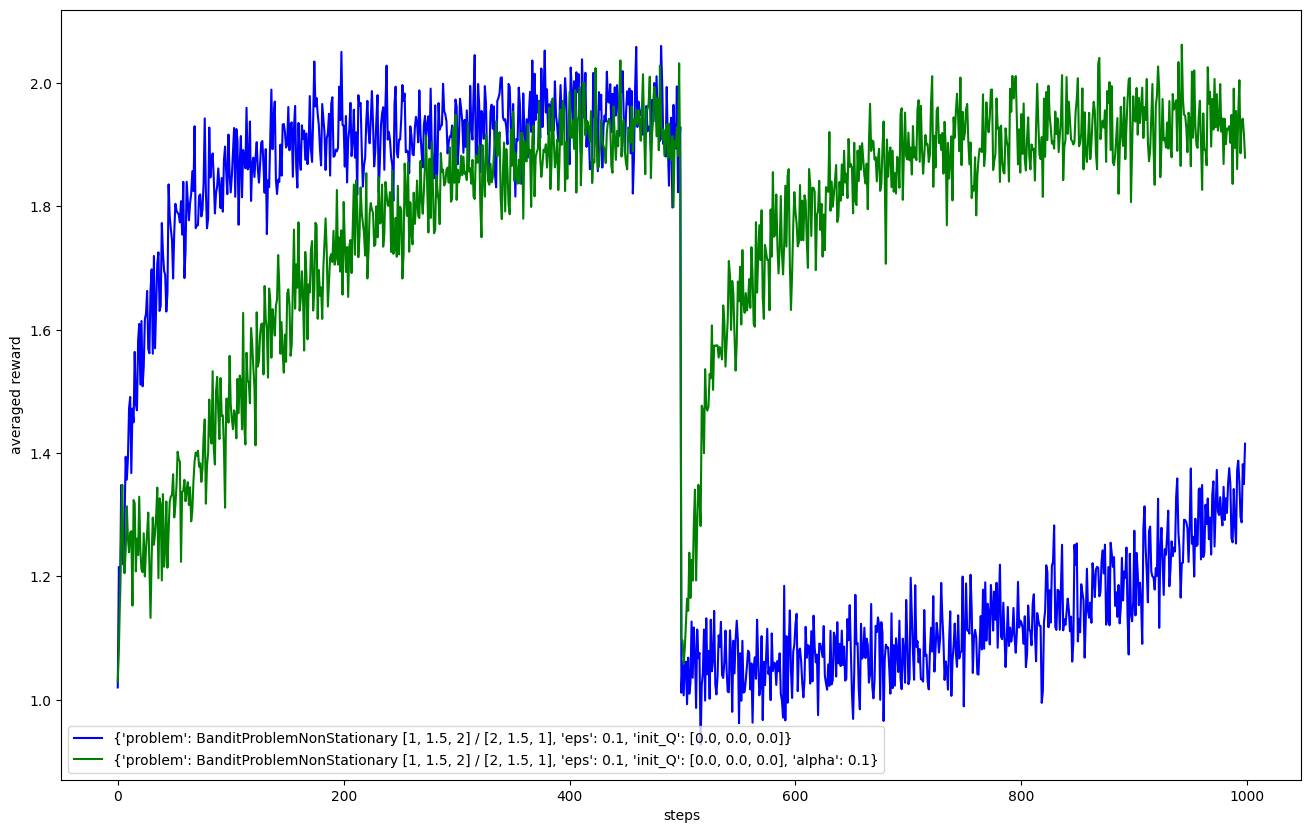

In [33]:
problem_ns = BanditProblemNonStationary([1, 1.5, 2], [2, 1.5, 1], change_step=500)

run_experiment(exp_egreedy, {"problem": problem_ns, "eps": 0.1, "init_Q": [0., 0., 0.]})
run_experiment(exp_egreedy_expmean, {"problem": problem_ns, "eps": 0.1, "init_Q": [0., 0., 0.], "alpha": 0.1})

show_plot()

**Question:** Why do we see the above behavior?


Vary the above experiment:

- try different q_a, q_b values: [1, 1.5, 2], [5., 3., 2.]
- try eps = 0.0
- try optimistic intialization [5., 5., 5.] (use floats!)

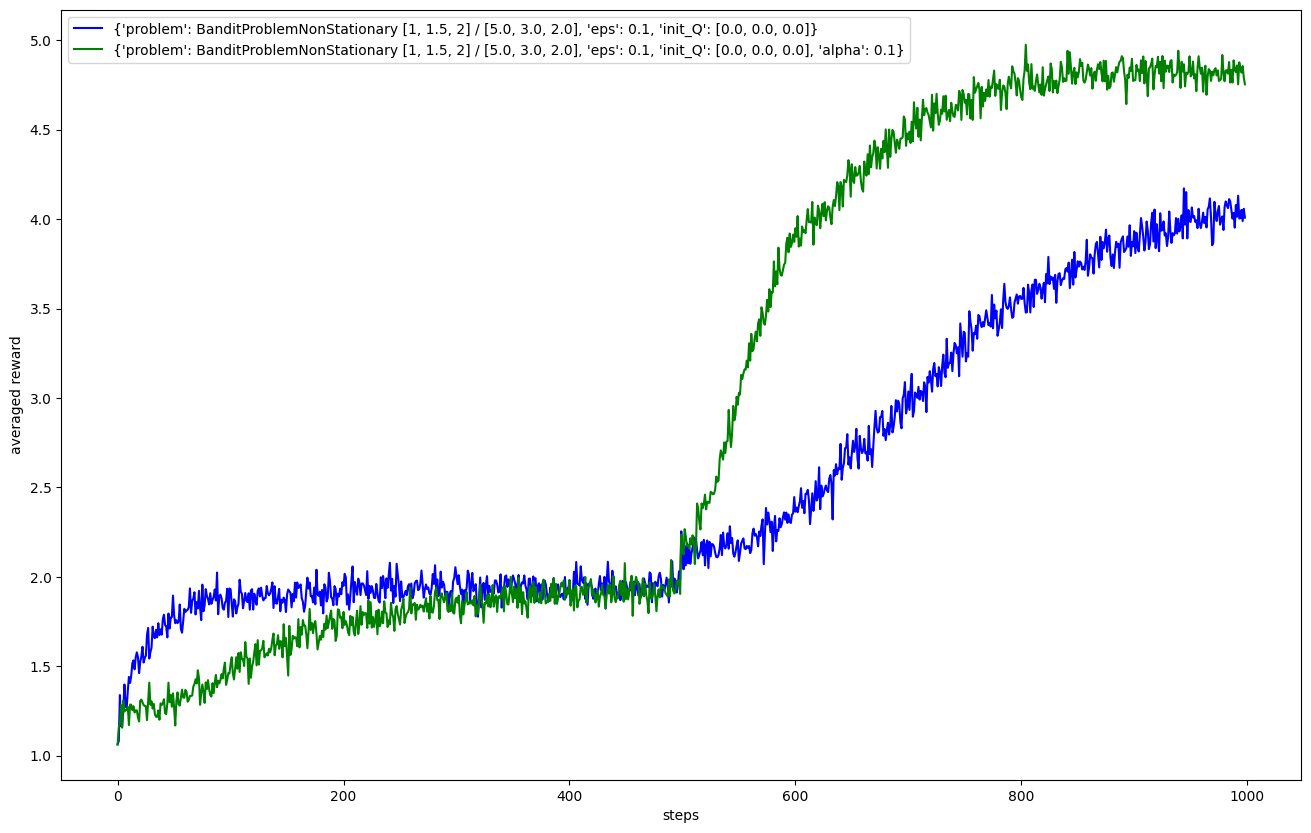

In [34]:
# try different q_a, q_b values: [1, 1.5, 2], [5., 3., 2.]
problem_ns = BanditProblemNonStationary([1, 1.5, 2], [5., 3., 2.], change_step=500)

run_experiment(exp_egreedy, {"problem": problem_ns, "eps": 0.1, "init_Q": [0., 0., 0.]})
run_experiment(exp_egreedy_expmean, {"problem": problem_ns, "eps": 0.1, "init_Q": [0., 0., 0.], "alpha": 0.1})

show_plot()

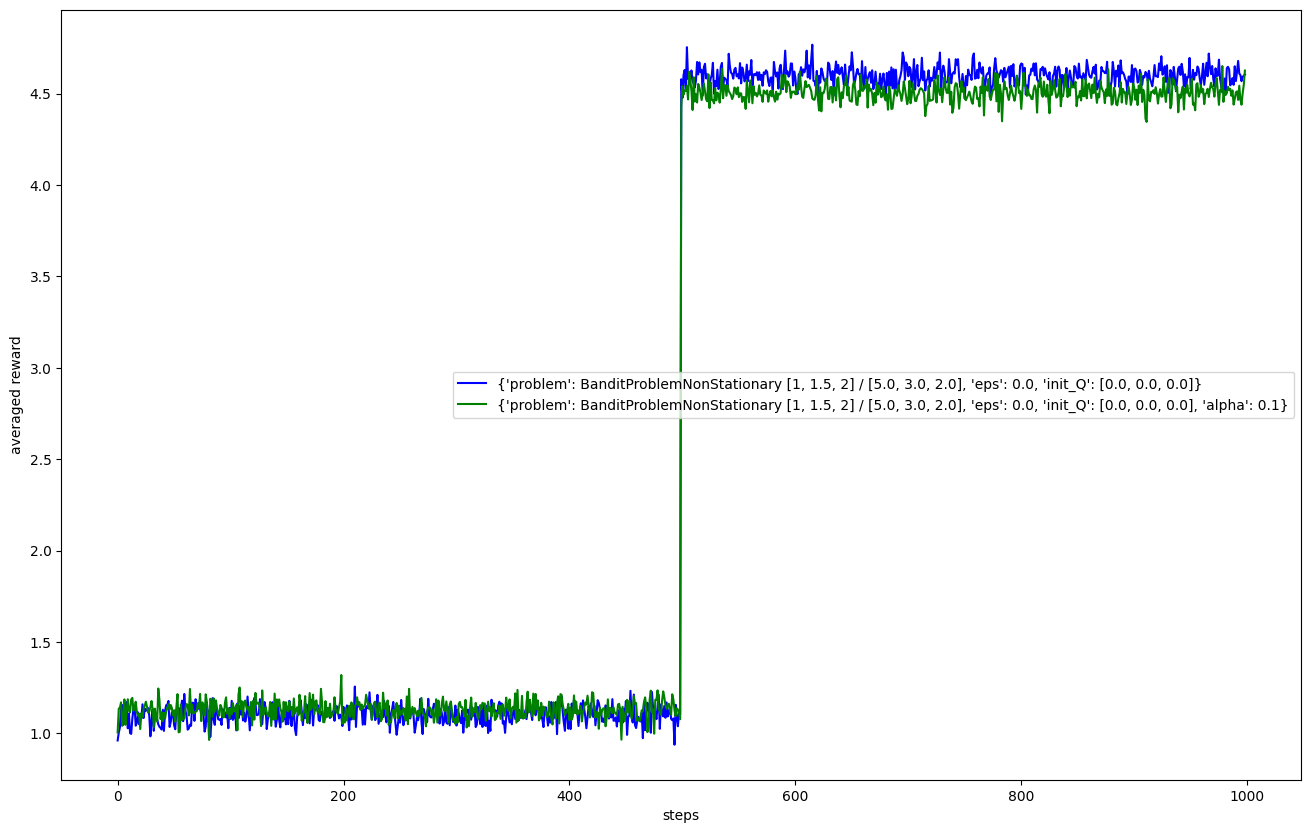

In [35]:
# try no exploration
problem_ns = BanditProblemNonStationary([1, 1.5, 2], [5., 3., 2.], change_step=500)

run_experiment(exp_egreedy, {"problem": problem_ns, "eps": 0., "init_Q": [0., 0., 0.]})
run_experiment(exp_egreedy_expmean, {"problem": problem_ns, "eps": 0., "init_Q": [0., 0., 0.], "alpha": 0.1})

show_plot()

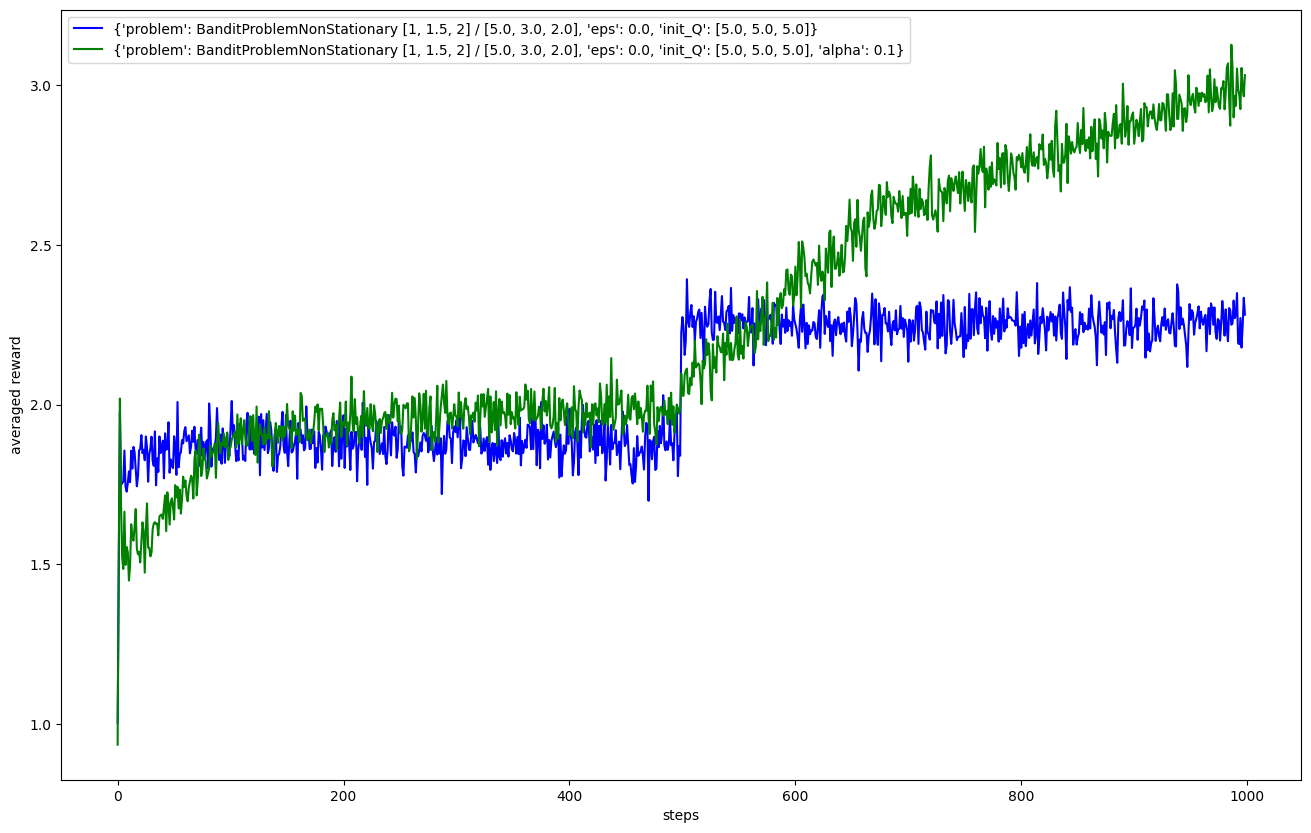

In [36]:
# try optimistic intialization [5., 5., 5.] no exploration
problem_ns = BanditProblemNonStationary([1, 1.5, 2], [5., 3., 2.], change_step=500)

run_experiment(exp_egreedy, {"problem": problem_ns, "eps": 0., "init_Q": [5., 5., 5.]})
run_experiment(exp_egreedy_expmean, {"problem": problem_ns, "eps": 0., "init_Q": [5., 5., 5.], "alpha": 0.1})

show_plot()

## Upper-Confidence-Bound (UCB) Action Selection

$\epsilon$-greedy strategy is "dull" in a sense - it just randomly tries actions.

A better way is to use our uncertainty about the values. UCB uses following action selection method:
$$ a_t = \text{argmax}_a \left[ Q_t(a) + c \sqrt{ \frac{\ln(t)}{N_t(a)} } \right] $$ N_t ... number of times pulling a\
c ... exploration constant

**Question:** What is the meaning of the UCB formula terms?



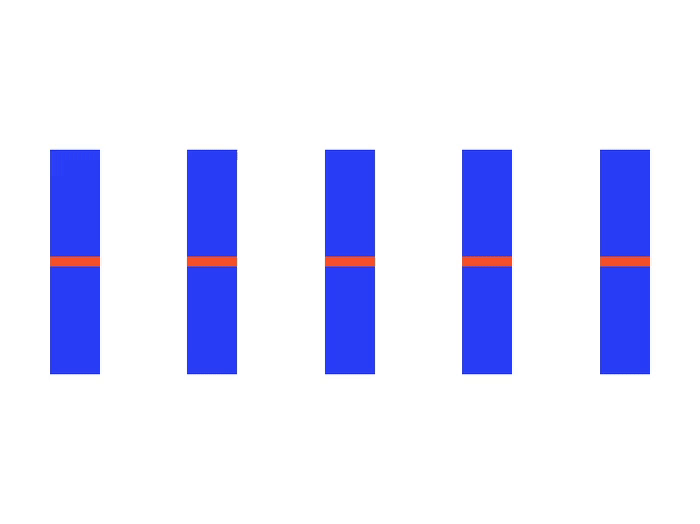

# Task 4

Let's implement it! Fill in the loop.

In [39]:
np.seterr(divide='ignore', invalid='ignore') # we'll use division by zero smartly

def exp_UCB(problem, c: float, init_Q: List[float] = [0., 0., 0.]) -> List[float]:
  Q = np.array(init_Q, dtype=np.float32)                      # our current estimate; np.array copies the values
  a_count = np.zeros(problem.action_count(), dtype=np.int32)  # number of times a was selected
  r_history = []

  problem.reset()

  for step in range(1, 1000):
    # TODO: fill the loop; use the fact that x/0 == inf in numpy
    ucb = Q + c * np.sqrt(np.log(step)/a_count)
    a = np.argmax(ucb)

    r = problem.sample(a)
    a_count[a] += 1

    Q[a] = Q[a] + (r - Q[a])/a_count[a]

    r_history.append(r)
    # Your code here
    # raise NotImplementedError

  return r_history

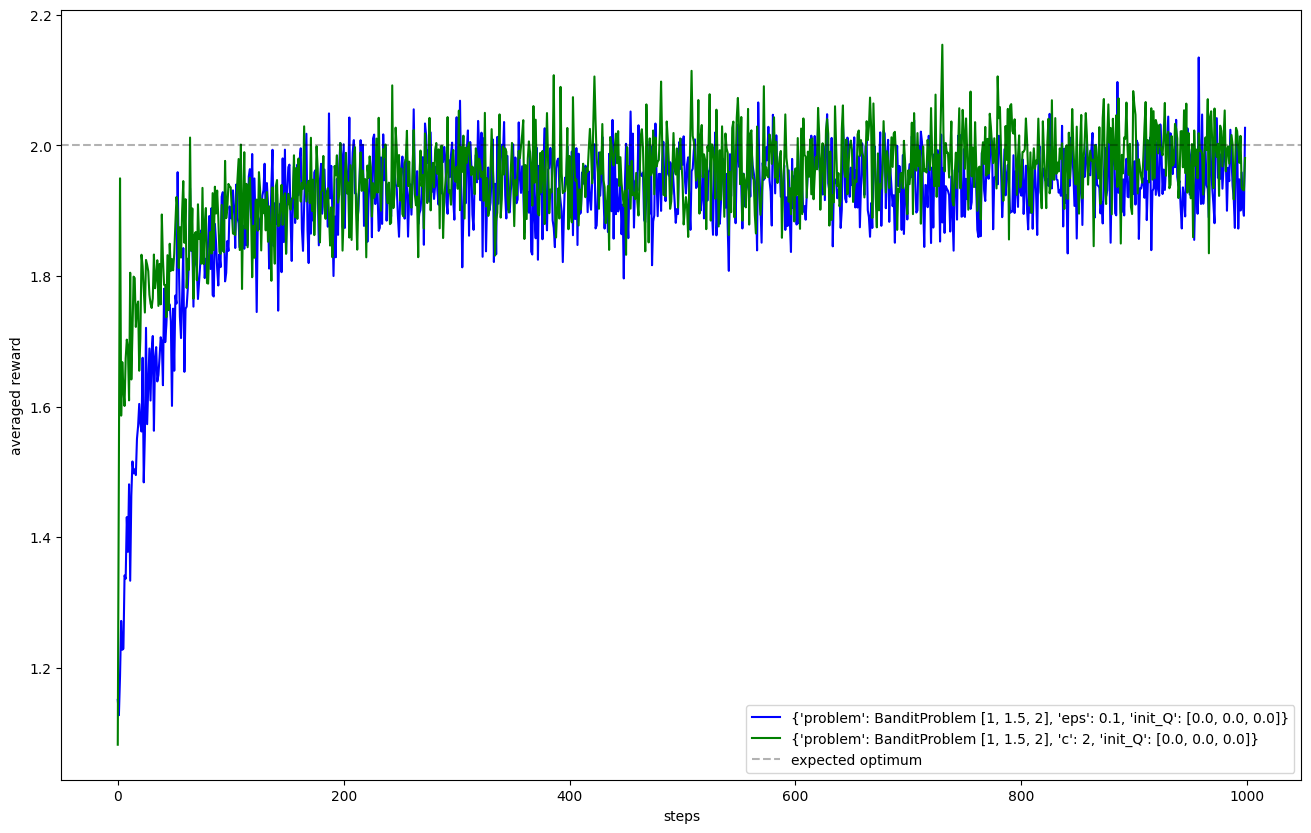

In [40]:
run_experiment(exp_egreedy, {"problem": problem, "eps": 0.1, "init_Q": [0., 0., 0.]})
run_experiment(exp_UCB, {"problem": problem, "c": 2, "init_Q": [0., 0., 0.]})

plt.axhline(2., linestyle='--', color='k', alpha=0.3, label='expected optimum')

show_plot()

And let's try for the non-stationary problem.

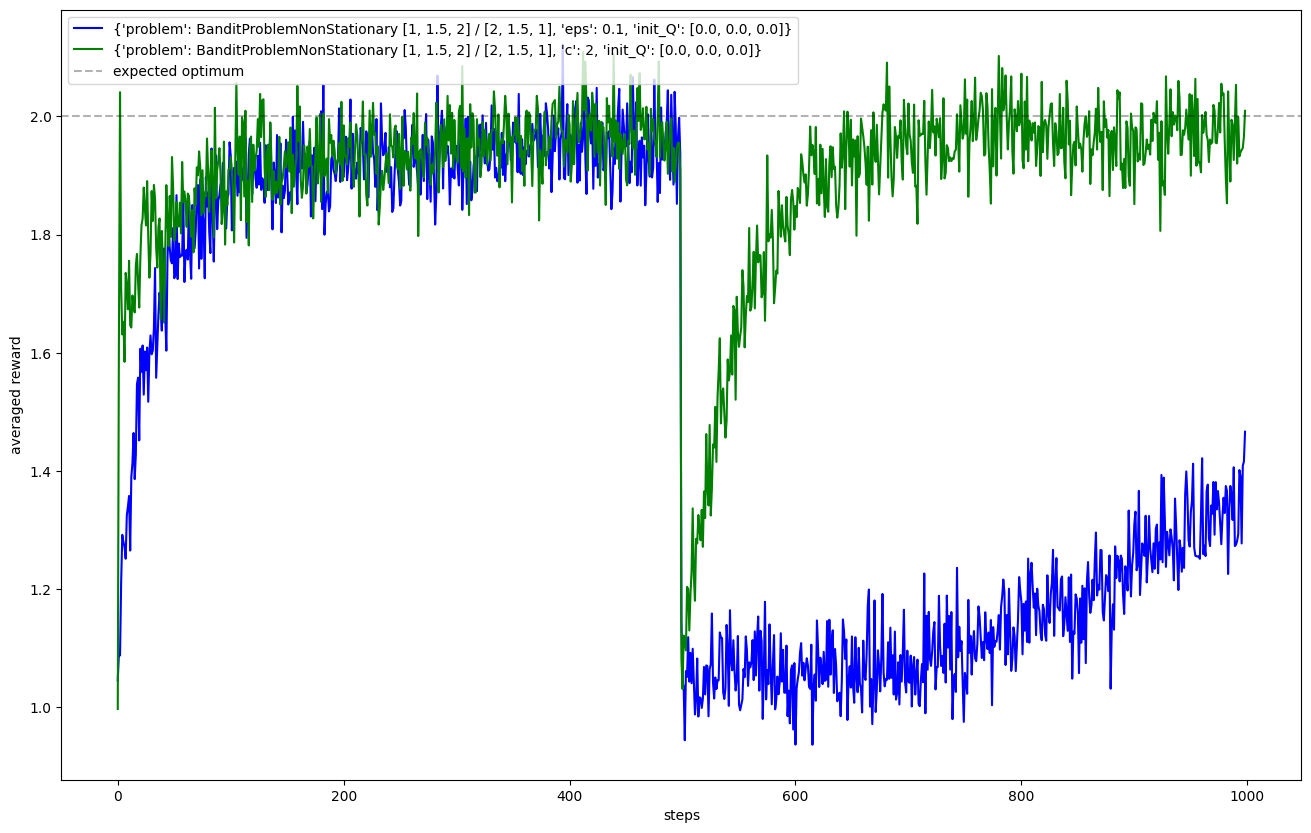

In [41]:
problem_ns = BanditProblemNonStationary([1, 1.5, 2], [2, 1.5, 1], change_step=500)

run_experiment(exp_egreedy, {"problem": problem_ns, "eps": 0.1, "init_Q": [0., 0., 0.]})
run_experiment(exp_UCB, {"problem": problem_ns, "c": 2, "init_Q": [0., 0., 0.]})

plt.axhline(2., linestyle='--', color='k', alpha=0.3, label='expected optimum')

show_plot()

**Question**: See the result above. Is UCB suitable to a non-stationary problem?

